# Coursework 1

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework1.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

In [2]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider

# Seed a random number generator
seed = 11102019 
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)

KeysView(<numpy.lib.npyio.NpzFile object at 0x000001CBFE4E46A0>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x000001CBFE4E4250>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: 5.7s to complete
    error(train)=9.06e-01, acc(train)=7.37e-01, error(valid)=9.22e-01, acc(valid)=7.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 6.3s to complete
    error(train)=7.00e-01, acc(train)=7.90e-01, error(valid)=7.37e-01, acc(valid)=7.76e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3: 5.3s to complete
    error(train)=6.05e-01, acc(train)=8.11e-01, error(valid)=6.57e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 5.3s to complete
    error(train)=5.54e-01, acc(train)=8.24e-01, error(valid)=6.18e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5: 5.3s to complete
    error(train)=5.04e-01, acc(train)=8.38e-01, error(valid)=5.81e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 5.3s to complete
    error(train)=4.81e-01, acc(train)=8.45e-01, error(valid)=5.68e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7: 5.3s to complete
    error(train)=4.64e-01, acc(train)=8.47e-01, error(valid)=5.60e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8: 5.3s to complete
    error(train)=4.41e-01, acc(train)=8.53e-01, error(valid)=5.51e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9: 5.3s to complete
    error(train)=4.15e-01, acc(train)=8.63e-01, error(valid)=5.37e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10: 5.3s to complete
    error(train)=4.08e-01, acc(train)=8.63e-01, error(valid)=5.41e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11: 5.4s to complete
    error(train)=3.87e-01, acc(train)=8.72e-01, error(valid)=5.30e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12: 5.4s to complete
    error(train)=3.81e-01, acc(train)=8.71e-01, error(valid)=5.38e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13: 5.4s to complete
    error(train)=3.81e-01, acc(train)=8.70e-01, error(valid)=5.46e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14: 5.4s to complete
    error(train)=3.72e-01, acc(train)=8.74e-01, error(valid)=5.48e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15: 5.4s to complete
    error(train)=3.61e-01, acc(train)=8.76e-01, error(valid)=5.42e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16: 5.4s to complete
    error(train)=3.51e-01, acc(train)=8.79e-01, error(valid)=5.41e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17: 5.4s to complete
    error(train)=3.56e-01, acc(train)=8.77e-01, error(valid)=5.57e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18: 5.4s to complete
    error(train)=3.32e-01, acc(train)=8.85e-01, error(valid)=5.38e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 5.4s to complete
    error(train)=3.25e-01, acc(train)=8.88e-01, error(valid)=5.43e-01, acc(valid)=8.33e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20: 5.4s to complete
    error(train)=3.21e-01, acc(train)=8.88e-01, error(valid)=5.47e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21: 5.4s to complete
    error(train)=3.15e-01, acc(train)=8.91e-01, error(valid)=5.49e-01, acc(valid)=8.29e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22: 5.4s to complete
    error(train)=3.10e-01, acc(train)=8.92e-01, error(valid)=5.48e-01, acc(valid)=8.31e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23: 5.4s to complete
    error(train)=3.08e-01, acc(train)=8.93e-01, error(valid)=5.63e-01, acc(valid)=8.28e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24: 5.8s to complete
    error(train)=3.03e-01, acc(train)=8.93e-01, error(valid)=5.65e-01, acc(valid)=8.30e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25: 6.5s to complete
    error(train)=3.00e-01, acc(train)=8.94e-01, error(valid)=5.63e-01, acc(valid)=8.25e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26: 5.5s to complete
    error(train)=2.95e-01, acc(train)=8.95e-01, error(valid)=5.79e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27: 4.5s to complete
    error(train)=2.89e-01, acc(train)=8.98e-01, error(valid)=5.73e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28: 5.3s to complete
    error(train)=2.81e-01, acc(train)=9.00e-01, error(valid)=5.77e-01, acc(valid)=8.26e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 5.5s to complete
    error(train)=2.81e-01, acc(train)=8.99e-01, error(valid)=5.83e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30: 5.4s to complete
    error(train)=2.83e-01, acc(train)=9.00e-01, error(valid)=5.95e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31: 5.5s to complete
    error(train)=2.74e-01, acc(train)=9.01e-01, error(valid)=5.92e-01, acc(valid)=8.24e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32: 5.3s to complete
    error(train)=2.72e-01, acc(train)=9.02e-01, error(valid)=6.06e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33: 5.5s to complete
    error(train)=2.66e-01, acc(train)=9.05e-01, error(valid)=6.00e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34: 5.3s to complete
    error(train)=2.62e-01, acc(train)=9.06e-01, error(valid)=6.04e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35: 5.5s to complete
    error(train)=2.64e-01, acc(train)=9.05e-01, error(valid)=6.10e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36: 5.4s to complete
    error(train)=2.67e-01, acc(train)=9.03e-01, error(valid)=6.27e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37: 5.5s to complete
    error(train)=2.59e-01, acc(train)=9.06e-01, error(valid)=6.22e-01, acc(valid)=8.22e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38: 5.3s to complete
    error(train)=2.58e-01, acc(train)=9.06e-01, error(valid)=6.32e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 5.5s to complete
    error(train)=2.56e-01, acc(train)=9.06e-01, error(valid)=6.34e-01, acc(valid)=8.19e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40: 5.3s to complete
    error(train)=2.49e-01, acc(train)=9.10e-01, error(valid)=6.36e-01, acc(valid)=8.21e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41: 5.5s to complete
    error(train)=2.41e-01, acc(train)=9.14e-01, error(valid)=6.32e-01, acc(valid)=8.23e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42: 5.4s to complete
    error(train)=2.47e-01, acc(train)=9.09e-01, error(valid)=6.51e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43: 5.5s to complete
    error(train)=2.41e-01, acc(train)=9.12e-01, error(valid)=6.54e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44: 5.3s to complete
    error(train)=2.42e-01, acc(train)=9.11e-01, error(valid)=6.64e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45: 5.5s to complete
    error(train)=2.39e-01, acc(train)=9.12e-01, error(valid)=6.65e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46: 5.4s to complete
    error(train)=2.34e-01, acc(train)=9.15e-01, error(valid)=6.70e-01, acc(valid)=8.18e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47: 5.2s to complete
    error(train)=2.44e-01, acc(train)=9.11e-01, error(valid)=6.83e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48: 5.3s to complete
    error(train)=2.31e-01, acc(train)=9.15e-01, error(valid)=6.85e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 5.5s to complete
    error(train)=2.24e-01, acc(train)=9.19e-01, error(valid)=6.85e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 4.9s to complete
    error(train)=2.21e-01, acc(train)=9.20e-01, error(valid)=6.85e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51: 4.9s to complete
    error(train)=2.22e-01, acc(train)=9.19e-01, error(valid)=6.98e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 52: 5.4s to complete
    error(train)=2.20e-01, acc(train)=9.19e-01, error(valid)=7.02e-01, acc(valid)=8.17e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 53: 5.5s to complete
    error(train)=2.24e-01, acc(train)=9.17e-01, error(valid)=7.18e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 54: 5.4s to complete
    error(train)=2.29e-01, acc(train)=9.14e-01, error(valid)=7.28e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 55: 5.3s to complete
    error(train)=2.14e-01, acc(train)=9.20e-01, error(valid)=7.09e-01, acc(valid)=8.15e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 56: 5.4s to complete
    error(train)=2.09e-01, acc(train)=9.23e-01, error(valid)=7.17e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 57: 5.3s to complete
    error(train)=2.14e-01, acc(train)=9.20e-01, error(valid)=7.31e-01, acc(valid)=8.13e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 58: 5.3s to complete
    error(train)=2.08e-01, acc(train)=9.23e-01, error(valid)=7.35e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 59: 5.3s to complete
    error(train)=2.04e-01, acc(train)=9.24e-01, error(valid)=7.38e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 60: 5.4s to complete
    error(train)=2.15e-01, acc(train)=9.20e-01, error(valid)=7.54e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 61: 5.4s to complete
    error(train)=2.04e-01, acc(train)=9.25e-01, error(valid)=7.49e-01, acc(valid)=8.16e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 62: 5.3s to complete
    error(train)=2.03e-01, acc(train)=9.24e-01, error(valid)=7.61e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 63: 5.4s to complete
    error(train)=2.02e-01, acc(train)=9.24e-01, error(valid)=7.67e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 64: 5.4s to complete
    error(train)=2.13e-01, acc(train)=9.19e-01, error(valid)=7.82e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 65: 5.4s to complete
    error(train)=1.95e-01, acc(train)=9.28e-01, error(valid)=7.61e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 66: 5.5s to complete
    error(train)=2.12e-01, acc(train)=9.19e-01, error(valid)=7.90e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 67: 5.3s to complete
    error(train)=1.93e-01, acc(train)=9.28e-01, error(valid)=7.86e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 68: 5.4s to complete
    error(train)=1.98e-01, acc(train)=9.25e-01, error(valid)=7.89e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 69: 5.3s to complete
    error(train)=1.89e-01, acc(train)=9.29e-01, error(valid)=8.01e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 70: 5.3s to complete
    error(train)=1.95e-01, acc(train)=9.25e-01, error(valid)=8.08e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 71: 5.4s to complete
    error(train)=1.93e-01, acc(train)=9.27e-01, error(valid)=8.16e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 72: 5.4s to complete
    error(train)=1.82e-01, acc(train)=9.33e-01, error(valid)=8.05e-01, acc(valid)=8.14e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 73: 5.3s to complete
    error(train)=1.96e-01, acc(train)=9.27e-01, error(valid)=8.34e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 74: 5.4s to complete
    error(train)=1.85e-01, acc(train)=9.31e-01, error(valid)=8.15e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 75: 5.4s to complete
    error(train)=1.81e-01, acc(train)=9.32e-01, error(valid)=8.28e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 76: 5.3s to complete
    error(train)=1.84e-01, acc(train)=9.30e-01, error(valid)=8.36e-01, acc(valid)=8.09e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 77: 5.3s to complete
    error(train)=1.82e-01, acc(train)=9.31e-01, error(valid)=8.43e-01, acc(valid)=8.11e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 78: 5.4s to complete
    error(train)=1.87e-01, acc(train)=9.29e-01, error(valid)=8.56e-01, acc(valid)=8.06e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 79: 5.3s to complete
    error(train)=1.82e-01, acc(train)=9.32e-01, error(valid)=8.54e-01, acc(valid)=8.12e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 80: 6.7s to complete
    error(train)=1.75e-01, acc(train)=9.34e-01, error(valid)=8.65e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 81: 5.7s to complete
    error(train)=1.76e-01, acc(train)=9.34e-01, error(valid)=8.60e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 82: 5.7s to complete
    error(train)=1.77e-01, acc(train)=9.33e-01, error(valid)=8.67e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 83: 5.7s to complete
    error(train)=1.86e-01, acc(train)=9.29e-01, error(valid)=8.99e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 84: 5.6s to complete
    error(train)=1.73e-01, acc(train)=9.34e-01, error(valid)=8.87e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 85: 4.9s to complete
    error(train)=1.72e-01, acc(train)=9.35e-01, error(valid)=8.96e-01, acc(valid)=8.10e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 86: 6.1s to complete
    error(train)=1.70e-01, acc(train)=9.36e-01, error(valid)=8.99e-01, acc(valid)=8.04e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 87: 6.7s to complete
    error(train)=1.81e-01, acc(train)=9.31e-01, error(valid)=9.13e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 88: 5.8s to complete
    error(train)=1.68e-01, acc(train)=9.36e-01, error(valid)=9.14e-01, acc(valid)=8.08e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 89: 5.7s to complete
    error(train)=1.71e-01, acc(train)=9.33e-01, error(valid)=9.25e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 90: 5.4s to complete
    error(train)=1.74e-01, acc(train)=9.32e-01, error(valid)=9.28e-01, acc(valid)=8.05e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 91: 5.9s to complete
    error(train)=1.68e-01, acc(train)=9.36e-01, error(valid)=9.46e-01, acc(valid)=8.00e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 92: 5.4s to complete
    error(train)=1.71e-01, acc(train)=9.34e-01, error(valid)=9.32e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 93: 5.0s to complete
    error(train)=1.64e-01, acc(train)=9.38e-01, error(valid)=9.37e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 94: 6.0s to complete
    error(train)=1.67e-01, acc(train)=9.35e-01, error(valid)=9.52e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 95: 6.0s to complete
    error(train)=1.68e-01, acc(train)=9.35e-01, error(valid)=9.60e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 96: 6.0s to complete
    error(train)=1.75e-01, acc(train)=9.30e-01, error(valid)=9.88e-01, acc(valid)=7.96e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 97: 6.0s to complete
    error(train)=1.57e-01, acc(train)=9.41e-01, error(valid)=9.63e-01, acc(valid)=8.03e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 98: 6.0s to complete
    error(train)=1.54e-01, acc(train)=9.42e-01, error(valid)=9.64e-01, acc(valid)=8.07e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 99: 6.0s to complete
    error(train)=1.67e-01, acc(train)=9.36e-01, error(valid)=9.87e-01, acc(valid)=8.01e-01


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100: 5.8s to complete
    error(train)=1.59e-01, acc(train)=9.39e-01, error(valid)=9.99e-01, acc(valid)=8.02e-01


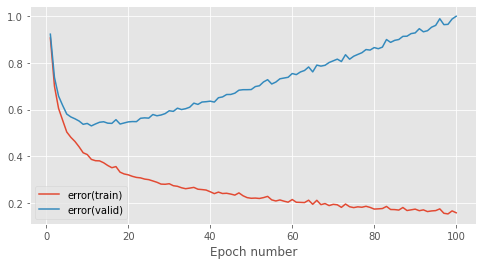

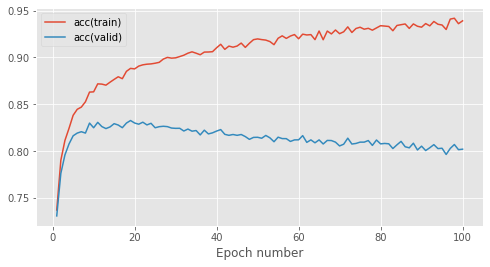

In [5]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser

#setup hyperparameters
learning_rate = 0.1
num_epochs = 100
stats_interval = 1
# input_dim, output_dim, hidden_dim = 784, 47, 100
input_dim, output_dim, hidden_dim = 784, 47, 128

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    # AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    # ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

#Remember to use notebook=False when you write a script to be run in a terminal
_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)